In [ ]:
import pyedflib
import mylib
import mvar
import mygraph
import numpy as np
import pandas as pd
from igraph import Graph
import re
import igraph

In [2]:
#%% Load data and store into a dataframe
path = './data/S001R01.edf'
print("Loading data from", path)
f = pyedflib.EdfReader(path)
# mylib.print_some_stuff(f)

data = mylib.edfToDataFrame(f)
f._close()
T = 1./f.getSampleFrequencies()[1]

Loading data from ./data/S001R01.edf


In [3]:
#%%
# 1.1

measures = data.T.values
N, n = measures.shape
p = 3
A_est, sigma = mvar.mvar_fit(measures, p)
sigma = np.diag(sigma)  # The noise for each time series
# compute DTF
print("Computing DFT")
D, freqs = mvar.DTF(A_est, sigma, T)
# compute PDC
print("Computing PDC")
# P, freqs = mvar.PDC(A_est, sigma)

Computing DFT
Computing PDC


In [4]:
#%%
# take take a graph relative to a specific frequency
freq = 10. # this is in Hz and roughly corresponds to Alpha (mu) ERD
#freq = 28   # this is in Hz and roughly corresponds to Beta ERS
print("Building network to analyse interactions at", freq, "Hz")
# select the correspondent weights
D = D[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)
G = Graph.Weighted_Adjacency(D.tolist(), mode = 0) # mode=0 is for directed / mode=1 is for indirected graph

# get channel names, cleaning replacing any dot with a void charachter
G.vs["label"] = list(map(lambda x: re.sub('\.', '', x), data.columns.values))
G = mygraph.add_brain_layout(G)

Building network to analyse interactions at 10.0 Hz


In [5]:
# %%
threshold = 0.05
print("Applying a threshold on network density of", round(threshold*100), "%")
G = mygraph.applyTreshold(G, threshold)


Applying a threshold on network density of 5 %


Look at the readme for instructions to install `bct`

In [6]:
#%% 2.2
import bct

print("Calculating Small World Index...")

Actual = np.array(G.get_adjacency(attribute = "weight").data)
Lattice, a, b, iter2 = bct.latmio_dir(Actual, 20, D = None)
Random, iter1 = bct.randmio_dir(Actual, 20)

"""
# Bootstrap
B = 3
Lr = np.array([])
Cr = np.array([])
for i in range(B):
    print(i, Lr)
    Random, iter1 = bct.randmio_dir(Actual, 20)
    print(Random[0,1])
    np.append(Lr, Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True))
    np.append(Cr, Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_avglocal_undirected())
Lr = Lr.mean()
Cr = Cr.mean()
"""

L = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).average_path_length(directed = True)
Ll = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).average_path_length(directed = True)
Lr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True)

C = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).transitivity_avglocal_undirected()
Cl = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).transitivity_avglocal_undirected()
Cr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_avglocal_undirected()

SWI = mylib.swi(L, Ll, Lr, C, Cl, Cr)
print("SWI =", SWI)


Calculating Small World Index...
SWI = -5.044642734712829


Making a topological representation


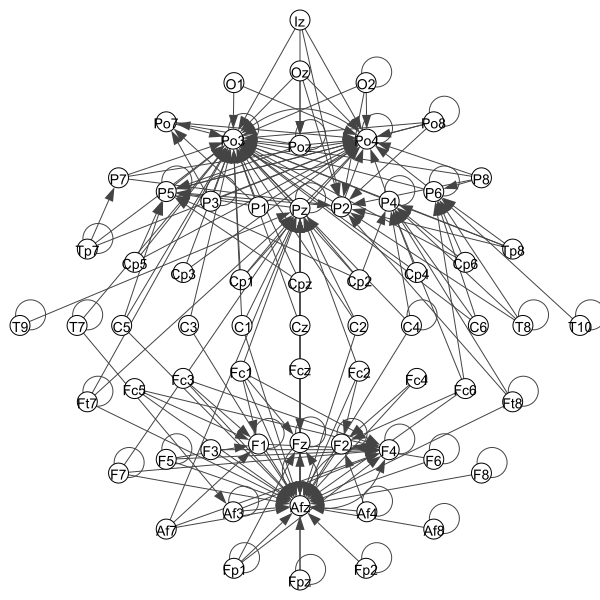

In [8]:
#%%
print("Making a topological representation")
visual_style = {}
visual_style["vertex_size"] = 20
visual_style["vertex_color"] = "white"
visual_style["vertex_label"] = G.vs["label"]
visual_style["edge_width"] = [1 + 2 * int(weight) for weight in G.es["weight"]]
visual_style["layout"] = G.vs["coordinates"]
igraph.plot(G, **visual_style)


In [9]:
#%%
# 2.1
print("Macroscopic Network Analysis")
# global clustering coefficient
# https://igraph.org/python/doc/igraph.Graph-class.html#transitivity_avglocal_undirected
print("global clustering coefficient = ", round(G.transitivity_avglocal_undirected(), 3))

# average path length
# https://igraph.org/python/doc/igraph.GraphBase-class.html#average_path_length
print("global average path lenght = ", round(G.average_path_length(directed = True), 3))

print("Microscopic Network Analysis")
local_ind = pd.DataFrame.from_dict(      {
                "channel" : G.vs["label"] ,
                "degree" : G.strength(mode = 3),
                "out-degree" : G.strength(mode = 1),
                "in-degree" : G.strength(mode = 2)
                }
        )

local_ind.set_index("channel", inplace = True)
print("Top 10 channels by degree\n", local_ind.sort_values(by = "degree", ascending = False)[1:10]["degree"])
print("Top 10 channels by OUT degree\n", local_ind.sort_values(by = "out-degree", ascending = False)[1:10]["out-degree"])
print("Top 10 channels by IN degree\n", local_ind.sort_values(by = "in-degree", ascending = False)[1:10]["in-degree"])



# 2.7
local_ind = pd.DataFrame.from_dict(      {
                "channel" : G.vs["label"] ,
                "strength" : G.strength(mode = 3,  weights = "weight"),
                "out-strength" : G.strength(mode = 1,  weights = "weight"),
                "in-strength" : G.strength(mode = 2,  weights = "weight")
                }
        )

local_ind.set_index("channel", inplace = True)
print("Top 10 channels by generalized degree\n", local_ind.sort_values(by = "strength", ascending = False)[1:10]["strength"])
print("Top 10 channels by generalized OUT degree\n", local_ind.sort_values(by = "out-strength", ascending = False)[1:10]["out-strength"])
print("Top 10 channels by generalized IN degree\n", local_ind.sort_values(by = "in-strength", ascending = False)[1:10]["in-strength"])


Macroscopic Network Analysis
global clustering coefficient =  0.629
global average path lenght =  1.682
Microscopic Network Analysis
Top 10 channels by degree
 channel
Afz    34.0
Po4    24.0
Pz     20.0
F4     14.0
P5     13.0
P4     13.0
P2     12.0
P6     11.0
F1      9.0
Name: degree, dtype: float64
Top 10 channels by OUT degree
 channel
Po8    5.0
Poz    5.0
Iz     4.0
P1     4.0
F7     4.0
Ft7    4.0
Ft8    4.0
Af7    4.0
T8     4.0
Name: out-degree, dtype: float64
Top 10 channels by IN degree
 channel
Afz    31.0
Po4    22.0
Pz     16.0
F4     12.0
P5     10.0
P4     10.0
P2      9.0
P6      8.0
Fz      6.0
Name: in-degree, dtype: float64
Top 10 channels by generalized degree
 channel
Afz    13.473430
Po4    10.041832
Pz      7.020175
P4      5.114191
F4      5.039221
P5      4.351623
P6      4.329907
P2      4.069092
F1      3.367227
Name: strength, dtype: float64
Top 10 channels by generalized OUT degree
 channel
Po8    1.813204
Fc1    1.675881
Iz     1.572640
Oz     1.563477


In [10]:
#%%
# 2.4 Study the behaviour of global graph indices in function of network density
print("Studying the behaviour of global graph indices in function of network density...")
densities = [0.05, 0.1, 0.2, 0.3, 0.5] # edit these with the ones provided by the prof

clustering_coeffs = []
average_path_lengths =  []
# there is a specific reason why we start from higher densities and then we
# decrease it: the function applyThreshold takes a graph and simply picks less 
# important edges (to which correspond low weights) erasing them from the network:
# to do that it has to find the minimum above N* x N* weights. 
# This is quite computationally expensive in our simple implementation:
# to speed up a bit our analysis we put the function in the condition of having
# at each step a smaller amount N*, avoiding to replicate the same minimizations
# multiple times
G = Graph.Weighted_Adjacency(D.tolist(), mode = 0)
for density in densities[::-1]:
    G = mygraph.applyTreshold(G, density)
    clustering_coeffs.append(G.transitivity_avglocal_undirected())
    average_path_lengths.append(G.average_path_length(directed = False, unconn=True))
    

Studying the behaviour of global graph indices in function of network density...


Ploting the result of the analysis


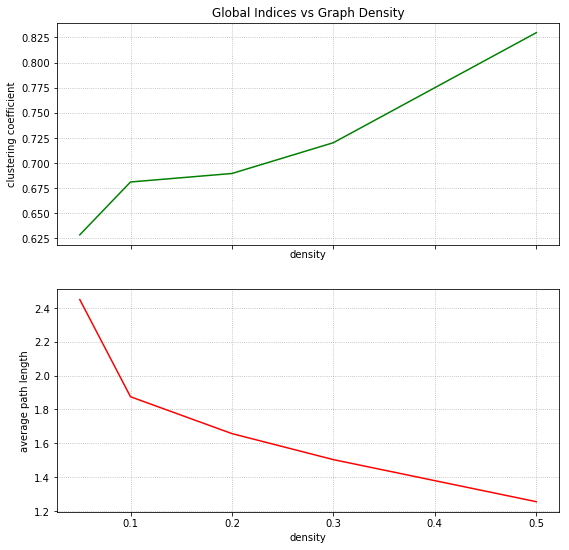

In [11]:
print("Ploting the result of the analysis")
mylib.plot_analysis(densities, clustering_coeffs, average_path_lengths)

In [ ]:
#%% 3 Motif analysis

path = './data/inputForMA.txt'
print("Writing input file for Motif Analysis to", path)
mylib.write_inputFileForMotifAnalysis(G, file = path)
print("\nDone")